In [1]:
import numpy as np
from astroquery.skyview import SkyView

import urllib.request
import os.path as path

from astropy.io import fits
from astropy.stats import sigma_clipped_stats

import glob

from PIL import Image

import matplotlib.pyplot as plt

In [2]:
with open('combined_catalogue_data.txt', 'r') as f:
    data = f.read().splitlines()
    
dataset = []

# Splitting out the columns
for i in range (0, len(data)):
    
    columns = data[i].split()
    
    if i == 0:
    
        dataset = np.asarray(columns[0:2]).astype(float)
        
    else:
        
        columns = np.asarray(columns[0:2]).astype(float)
        dataset = np.concatenate((dataset, columns))

# Final dataset with arrays of data for individual objects
dataset = np.reshape(dataset, (-1, 2))

In [3]:
# Should be 2100
len(dataset)

2100

In [4]:
# Function to generate the appropriate filename convention for any entry    
def name_string(entry):
    """Simplified naming function that only requires RA & dec"""
    
    ra = '{:07.3f}'.format(entry[0]*15)  # Moving both into degrees
    dec = '{:+08.3f}'.format(entry[1])  # Retaining sign to keep length consistent
    
    name = ra + '_' + dec
    
    return name

In [5]:
# Check this is behaving
# Should produce something formatted 'XXX.XXX±XXX.XXX'
name_string(dataset[0])

'000.395_-008.865'

In [6]:
def image_download(entry, survey='VLA FIRST (1.4 GHz)', pixels=300):
    """Download an image with the name format given by name_string"""
    
    # Creating the path to the file and the name it'll be saved as
    filename = './CRUMB/FITS/'+name_string(entry)+'.fits'
    
    # Preventing any duplicate downloads
    if path.exists(filename) == False:
    
        # Converting RA from hours to decimal degrees
        coords = (entry[0]*15).astype(str)+', '+entry[1].astype(str)
    
        # Download from SkyView
        location=SkyView.get_image_list(position=coords, survey=survey, pixels=pixels)
        
        try:
            
            urllib.request.urlretrieve(location[0], filename)
            print(filename)
            
        except:
            
            # If there's a problem, can still manually download from SkyView
            print('Problem with url', coords, name_string(entry)+'.fits')

In [7]:
# Hongming's image_convert function to create pngs
def image_convert(name, image_data):
    """
       This function writes a PNG file from a numpy array.
       Args:
       name: Name of the output file without the .png suffix
       image_data: Input numpy array
       Returns:
       Writes PNG file to disk.
       Raises:
       KeyError: Raises an exception.
    """
    im = Image.fromarray(image_data)
    im = im.convert('L')
    im.save(name+".png")
    return

In [8]:
# A modified version of Hongming's crop_center function
def crop_centre(img, cropx, cropy):
    """"
       This function crop images from centre to given size.
       Args:
       img: input image
       cropx: output image width
       cropy: output image height
       Returns:
       data of cropped img
       Raises:
    """
    
    xsize = np.shape(img)[0] # image width
    ysize = np.shape(img)[1] # image height
    startx = xsize//2-(cropx//2)
    starty = ysize//2-(cropy//2)
    img_slice = img[startx:startx+cropx,starty:starty+cropy]
    return img_slice

In [9]:
# From alkasm on stackoverflow
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (np.rint(w/2), np.rint(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

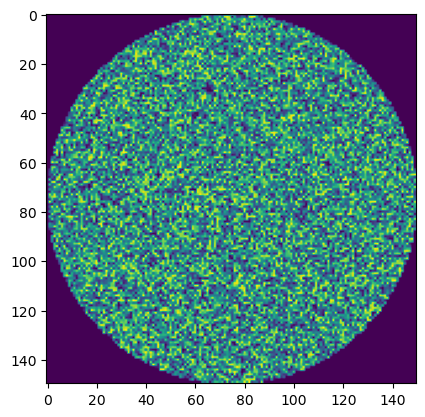

In [10]:
# Check the mask works
# Should produce a circle of random data surrounded by zeroes

testmatrix = np.random.rand(150,150)

mask=create_circular_mask(150, 150, radius=75)

subset = testmatrix[mask]
testmatrix[~mask] = 0

image_max, image_min = subset.max(), subset.min()
testmatrix[mask] = (testmatrix[mask] - image_min)/(image_max - image_min)

plt.imshow(testmatrix)
plt.show()

In [11]:
# A modified version of Hongming's read_fits_image function
def read_fits_image(fitsfile, extension='_F', cropsize=150, pixel_arcsec = 1.8, angularcrop=False):
    """
       This function extracts the image data from a FITS image, clips
       and linearly scales it.
       Args:
       fitsfile: Path to the input FITS file
       Returns:
       image_data: Numpy array containing image from FITS file
       Raises:
       KeyError: Raises an exception.
    """
    
    # Obtaining the naming convention
    namestring = fitsfile[13:28]
    
    with fits.open(fitsfile, ignore_missing_end=True) as hdu:
        image_data = hdu[0].data
        hdu.close()
    image_data = fits.getdata(fitsfile)
    
    # set pixels < 3*noise to zero:
    a = sigma_clipped_stats(image_data,sigma=3.0, maxiters=5)
    image_data[np.where(image_data<=3*a[2])] = 0.0

    image_data = crop_centre(image_data, cropsize, cropsize)
        
    if angularcrop == True:
        
        mask = create_circular_mask(cropsize, cropsize, radius = 75)
    
    if namestring == '161.634_+054.600':
        # This source loses data with the 150-diameter mask, so it doesn't get masked
        
        subset = image_data
        
        # normalise to [0, 1]:
        image_max, image_min = subset.max(), subset.min()
        image_data = (image_data - image_min)/(image_max - image_min)
        # remap to [0, 255] for greyscale:
        image_data*=255.0
        
    elif namestring == '176.113_+037.142':
        # This one per above
        
        subset = image_data
        
        # normalise to [0, 1]:
        image_max, image_min = subset.max(), subset.min()
        image_data = (image_data - image_min)/(image_max - image_min)
        # remap to [0, 255] for greyscale:
        image_data*=255.0
        
    else:
    
        subset = image_data[mask]
        image_data[~mask] = 0
    
        # normalise to [0, 1]:
        image_max, image_min = subset.max(), subset.min()
        image_data[mask] = (image_data[mask] - image_min)/(image_max - image_min)
        # remap to [0, 255] for greyscale:
        image_data*=255.0
    
    # Check if the file has already been saved as the final png
    if path.exists('./CRUMB/PNG/Scaled_Final/'+namestring+'.png') is False:
    
        # Save for a final time here, as 'name.png'
        image_convert('./CRUMB/PNG/Scaled_Final/'+namestring, image_data)
    
    return image_data

In [ ]:
# Image data should all be processed once this step is done

file_list = glob.glob('./CRUMB/FITS/*.fits')

# List of files confirmed to have missing data
blacklist = ['100_036.061+000.563_0.1400_0093.07', '200_003.198+000.788_0.1484_0026.82', '200_033.655+000.710_0.2900_0030.76', '210_348.925-000.435_0.0910_0050.37']

for i in range(len(file_list)):
    
    # Create images for any file not in the blacklist
    # These indices should pick up the naming convention
    # Will save them as a PNG with the same name as the fits files
    if file_list[i][18:52] not in blacklist:
        
        #print(file_list[i])
        image = read_fits_image(file_list[i], extension='_F', cropsize=150, angularcrop = True)

In [12]:
# Now collecting label data

with open('combined_catalogue_data.txt', 'r') as f:
    data = f.read().splitlines()

label_vector = []
    
# Splitting out the relevant columns
for i in range (0, len(data)):
    
    columns = data[i].split()
    
    labels = np.array((int(columns[2]), int(columns[3]), int(columns[4]), int(columns[5])))
    
    if i == 0:
    
        label_vector = labels
        
    else:
        
        label_vector = np.concatenate((label_vector, labels))
        
label_vector = np.reshape(label_vector, (-1, 4))

In [13]:
# Identify FRIs, FRIIs and hybrids based on labels

class_labels = []

fri_count = 0
frii_count = 0
hyb_count = 0

for i in range(len(label_vector)):
    
    if label_vector[i, 0] != -1:
        
        if label_vector[i, 0] < 5:
            
            class_labels.append('FRI')
            
            fri_count += 1
            
        elif label_vector[i, 0] > 7:
            
            class_labels.append('Hyb')
            
            hyb_count += 1
            
        else:
            
            class_labels.append('FRII')
            
            frii_count += 1
        
    elif label_vector[i, 1] != -1:
        
        if label_vector[i, 1] == 0:
            
            class_labels.append('FRI')
            
            fri_count += 1
        
        else:
            
            class_labels.append('FRII')
            
            frii_count += 1
        
    elif label_vector[i, 2] != -1:
        
        if label_vector[i, 1] == 1:
            
            class_labels.append('FRII')
            
            frii_count += 1
        
        else:
            
            class_labels.append('FRI')
            
            fri_count += 1
        
    elif label_vector[i, 3] != -1:
        
        class_labels.append('Hyb')
        
        hyb_count += 1

In [14]:
# Should have 1006 FRIs, 997 FRIIs and 97 hybrids

print('FRI:', fri_count, ', FRII:', frii_count, ', Hyb:', hyb_count)

FRI: 1006 , FRII: 997 , Hyb: 97


In [15]:
# Collect labels to be split into batches

# This source has an artefact that makes it not well suited to the training or valid set
# It's hence reserved for the test set
test_label = class_labels.pop(1538)

fri_index_list = np.squeeze(np.where(np.array(class_labels) == 'FRI'))
frii_index_list = np.squeeze(np.where(np.array(class_labels) == 'FRII'))
hyb_index_list = np.squeeze(np.where(np.array(class_labels) == 'Hyb'))

In [16]:
# Take as an input a list of file counts (vector), no. of batches and length of batches
# This handles batching imbalanced datasets to ensure that:
# a) There's a roughly even split of source classes in each batch
# b) At least one image of every class is present in the test set

def multiclass_batch(class_count, batches, batch_size, overflow=True):
    
    # Set as a np array to ensure all relevant mathematial functions behave
    class_count = np.array(class_count)
    len_class = len(class_count)
    
    # First check: sum up the total number of files and make sure it equals no. x length of batches
    # If not, throw an error that it doesn't divide neatly
    if sum(class_count)==(batches*batch_size):
        
        extra_count = 0
        
    elif sum(class_count)>(batches*batch_size):
          
        # Any overflow in length should go into the test batch; this will keep track of how many should go in
        extra_count = sum(class_count) - (batches*batch_size)
        
    else:
        
        print("Error: not enough images for this many batches")
        
    # Test batch section
    
    # Divide the vector by the no. of batches and floor it
    # If any entry equals zero, set it to one instead
    test_count = np.floor(class_count/batches)
    test_count[np.where(test_count == 0)] = 1
    
    # Check if the number of test entries divides neatly by the batch size 
    if sum(test_count) == batch_size and extra_count == 0:
        
        print("Test batch complete!")
        # Basically, if this is the case, it makes life a lot easier and the test batch is now done
    
    # If any extras need to be added:
    elif sum(test_count) == batch_size and extra_count != 0:
        
        # This needs to be written at some point
        print("Extra images needed for test batch")
    
    # If there's not enough entries    
    elif sum(test_count) < batch_size:
        
        # Find how many entries are left to fill, and which classes have the largest remainders when divided
        to_fill = (batch_size - sum(test_count) + extra_count).astype(int)
        remainder = class_count%batches
        
        # If there are fewer entries to be filled than there are classes
        if to_fill <= len_class:
        
            # Find the indices of the largest n entries' remainders, where n is the number of entries to fill
            indices = (-remainder).argsort()[:to_fill]
            
            # Add one to the counts for each of the n largest remainders
            for i in range(to_fill):
            
                test_count[indices[i]] = test_count[indices[i]] + 1
            
        # Otherwise, there are more entries to be filled than there are classes
        # Does the number to fill divide neatly by the number of classes?
        # If so, test_count just gets that number added to every entry
        elif to_fill%len_class == 0:
        
            test_count = test_count + (to_fill/len_class)
         
        # If not, add an even number to each, then add the remainder to the largest remaining classes
        else:
            
            for i in range(int(to_fill)):
                
                test_count = test_count + np.floor(to_fill/class_count)
                
                last_fill = to_fill%len_class
                
                indices = (-remainder).argsort()[:last_fill]
                
                # Add one to the counts for each of the n largest remainders
                for i in range(last_fill):
            
                    test_count[indices[i]] = test_count[indices[i]] + 1
    
    # Only remaining possibility is that there's too many entries
    else:
        
        # Find out how many extra entries there are, and which classes have the largest remainders when divided
        to_remove = test_count - batch_size - extra_count
        remainder = class_count%batches
        
        # Find the indices of the smallest n entries' remainders, where n is the number of entries to fill
        indices = (remainder).argsort()[:to_fill]
        
        # Prep for the while loop
        no_replaced = 0
        
        # Check if any of the chosen classes have only one image
        while any (test_count[indices] == 1) is True:
            
            # If they do, find how many
            to_replace = np.where(test_count[indices]) == 1
            no_to_replace = len(to_replace)
            
            # Find the next largest remainders
            index_replacements = (remainder).argsort()[to_fill+no_replaced:to_fill+no_replaced+no_to_replace]
            
            # Replace the previous entries
            for i in range(no_to_replace):
                
                indices[to_replace[i]] = index_replacements[i]
            
            # Note how many have now been replaced in case another pass is needed
            no_replaced = no_replaced + no_to_replaced
        
        # Now all the checks have been done, should be free to remove all necessary
        for i in range(to_fill):
            
            test_count[indices[i]] = test_count[indices[i]] - 1
 
    print(test_count)
    
    # Training batch section
    
    # Find the number of remaining entries
    training_count = class_count - test_count
    
    print(training_count)
    
    # Total no. of images of each class present in every batch:
    base_count = np.floor(training_count/(batches-1))
    
    # Number of remaining images of each class
    extra_count = training_count%(batches-1)
    
    # Check if the base count already contains batch_size images
    if sum(base_count) == batch_size:
        
        print("Training batches complete!")
        # This makes life easier! It's now done.
        
        training_count = np.array([base_count,]*(batches-1))
        
    else:
            
        # Find the number to add to each batch
        to_add = batch_size - sum(base_count)
            
        # Repeat the base_count vector (batches-1) times
        training_count = np.array([base_count,]*(batches-1))
        
        # For every row, to_add times
        for i in range(batches-1):
            
            for j in range(to_add.astype(int)):
                
                # Check which (if any) of the classes have images to use
                index_options = np.asarray(np.nonzero(extra_count)[0])
                
                # Select a random one of these indices
                index_choice = random.choice(index_options)
                
                # Add one to training_count in relevant entry; subtract one from extra_count in relevant entry
                training_count[i, index_choice] = training_count[i, index_choice] + 1
                extra_count[index_choice] = extra_count[index_choice] - 1
    
    output = np.vstack((training_count, test_count))
    
    return output

In [17]:
def randomise_by_index(inputlist,idx_list): # A helper function for later
 
    """
       Function to randomize an array of data
    """
     
    if len(inputlist)!=len(idx_list):
        print("These aren't the same length")
 
    outputlist = []
    for i in idx_list:
        outputlist.append(inputlist[i])
 
    return outputlist

In [ ]:
# Generate the lists of each class and randomly shuffle the order
all_files = sorted(np.array(glob.glob('./CRUMB/PNG/Scaled_Final/*.png')))

# Find all the files of each class
# The third class is here the source reserved for the test set seen before
cl0_files = np.take(all_files, fri_index_list)
cl1_files = np.take(all_files, frii_index_list)
cl2_files = np.take(all_files, hyb_index_list)
cl3_files = np.take(all_files, 1538)

cl0_labels = label_vector[fri_index_list]
cl1_labels = label_vector[frii_index_list]
cl2_labels = label_vector[hyb_index_list]
cl3_labels = label_vector[1538]

n_cl0 = len(cl0_files)
n_cl1 = len(cl1_files)
n_cl2 = len(cl2_files)
n_cl3 = len(cl3_files)

In [ ]:
# Should be './CRUMB/PNG/Scaled_Final/222.036_+016.578.png'
all_files[1538]

In [ ]:
# Directory to save batches in
    binddir = './CRUMB/CRUMB_batches/'

# Training plus test batches
nbatch = 7 # 

# No. of images per batch
pbatch = 300 #

# Label names
label_names = ['FRI', 'FRII', 'Hyb']

# Length of data arrays [npix x npix x greyscale = 150 x 150 x 1 = 22500]
nvis = 22500

# Generate the lists of each class and randomly shuffle the order
all_files = sorted(np.array(glob.glob('./CRUMB/PNG/Scaled_Final/*.png')))

cl0_files = np.take(all_files, fri_index_list)
cl1_files = np.take(all_files, frii_index_list)
cl2_files = np.take(all_files, hyb_index_list)
cl3_files = all_files[1538]

cl0_labels = label_vector[fri_index_list]
cl1_labels = label_vector[frii_index_list]
cl2_labels = label_vector[hyb_index_list]
cl3_labels = label_vector[1538]

n_cl0 = len(cl0_files)
n_cl1 = len(cl1_files)
n_cl2 = len(cl2_files)
n_cl3 = len(cl3_files)

# No. of images in each class    
class_count = np.asarray([1006, 996, 97, 1])

# Generate some matrices of how many of each class should go in each batch
batch_count = multiclass_batch(class_count, nbatch, pbatch)

# For tracking how many images have been used
count = np.zeros(4)   
    
for batch in range(nbatch):
 
    if (batch==(nbatch-1)):
        # the last batch is the test batch:
        oname = "test_batch"
        batch_label = 'testing batch 1 of 1'
    else:
        # everything else is a training batch:
        oname = "data_batch_"+str(batch+1)
        batch_label = 'training batch '+str(batch+1)+' of '+str(nbatch-1)
 
    # create empty arrays for the batches:
    labels=[];complete_labels=[];filedata=[];data=[];filenames=[]
    
    # Class 0
    for i in range(int(count[0]),int(count[0]+batch_count[batch,0])):
 
        filename = cl0_files[i]
        filenames.append(filename)
 
        labels.append(0)
    
        complete_label = cl0_labels[i]
        complete_labels.append(complete_label)
            
        im = Image.open(filename)
        im = (np.array(im))
        filedata = np.array(list(im), np.uint8)
        data.append(filedata)
        
    count[0] = count[0] + batch_count[batch,0]
 
    # Class 1
    for i in range(int(count[1]),int(count[1]+batch_count[batch,1])):
 
        filename = cl1_files[i]
        filenames.append(filename)
 
        labels.append(1)
    
        complete_label = cl1_labels[i]
        complete_labels.append(complete_label)

        im = Image.open(filename)
        im = (np.array(im))
        filedata = np.array(list(im), np.uint8)
        data.append(filedata)
        
    count[1] = count[1] + batch_count[batch,1]
        
    # Class 2
    for i in range(int(count[2]),int(count[2]+batch_count[batch,2])):
 
        filename = cl2_files[i]
        filenames.append(filename)
 
        labels.append(2)
    
        complete_label = cl2_labels[i]
        complete_labels.append(complete_label)
 
        im = Image.open(filename)
        im = (np.array(im))
        filedata = np.array(list(im), np.uint8)
        data.append(filedata)
        
    count[2] = count[2] + batch_count[batch,2]
    
    # Class 3
    
    if (batch==(nbatch-1)):
    
     for i in range(int(count[3]),int(count[3]+batch_count[batch,3])):
 
            filename = cl3_files
            filenames.append(filename)

            labels.append(1)

            complete_label = cl3_labels
            complete_labels.append(complete_label)
            
            im = Image.open(filename)
            im = (np.array(im))
            filedata = np.array(list(im), np.uint8)
            data.append(filedata)
        
            count[3] = count[3] + batch_count[batch,3]
    
    # randomise data in batch:
    idx_list = range(0,pbatch)
    labels = randomise_by_index(labels,idx_list)
    complete_labels = randomise_by_index(complete_labels,idx_list)
    data = randomise_by_index(data,idx_list)
    filenames = randomise_by_index(filenames,idx_list)

    # create dictionary of batch:
    dict = {
            'batch_label':batch_label,
            'labels':labels,
            'complete_labels':complete_labels,
            'data':data,
            'filenames':filenames
            }
 
    # write pickled output:
    with io.open(binddir+oname, 'wb') as f:
        pickle.dump(dict, f)
 
    # end batch loop

In [ ]:
# total number of samples per batch: [modified 20190925]
pbatch = 300

# label names: [modified 20190415]
label_names = ['FRI', 'FRII', 'Hyb']

# length of data arrays [npix x npix x rgb = 150 x 150 x 1 = 22500] [modified 20190415]
nvis = 22500

# ------------------------------------
# now write the meta data file:
oname = 'batches.meta'

# ------------------------------------
# create dictionary of batch:
dict = {
        'num_cases_per_batch':pbatch,
        'label_names':label_names,
        'num_vis':nvis,
        }

# ------------------------------------
# write pickled output:
with io.open(binddir+oname, 'wb') as f:
    pickle.dump(dict, f)

In [ ]:
# Method to import CRUMB and prepare for training

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torchvision import transforms

from CRUMB import CRUMB

batch_size = 80
imsize = 150 # this value is fixed

# ------------------------------------------------------------------------------------------------------
# import dataset:

# data augmentation

crop = transforms.CenterCrop(imsize)
rotate = transforms.RandomRotation([-180, 180])
totensor = transforms.ToTensor()
normalise = transforms.Normalize((0.0029,), (0.0341,)) # CRUMB mean and stdev

transforms = transforms.Compose([
    crop,
    rotate,
    totensor,
    normalise
])

# load training and test set
# this will download CRUMB to a directory called "crumb"
test_data = CRUMB('crumb', download=True, train=False, transform=transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
train_data = CRUMB('crumb', download=True, train=True, transform=transforms)
train_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)